<a href="https://colab.research.google.com/github/manarLABIDI/Fake_News_Detection/blob/main/Fake_news_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re, string, unicodedata
from string import punctuation
from termcolor import colored
from collections import Counter


from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from keras.preprocessing import text, sequence
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer

import nltk
from nltk.corpus import stopwords
from textblob import Word
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet


from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import set_config
set_config(print_changed_only = False)

print(colored("\nLIBRARIES WERE SUCCESFULLY IMPORTED...", "green"))


LIBRARIES WERE SUCCESFULLY IMPORTED...


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
true_news = pd.read_csv("/content/drive/MyDrive/Fake News Detection/True.csv")
fake_news = pd.read_csv("/content/drive/MyDrive/Fake News Detection/Fake.csv")

print(colored("\nDATASETS WERE SUCCESFULLY LOADED...", "green"))


DATASETS WERE SUCCESFULLY LOADED...


In [ ]:
true_news["news_class"], fake_news["news_class"] = 1, 0

news = pd.concat([true_news, fake_news])

print(colored("\nDATASETS WERE SUCCESFULLY MERGED...", "green"))


DATASETS WERE SUCCESFULLY MERGED...


In [ ]:
news.head()

,title,text,subject,date,news_class
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [ ]:
#get basic information about dataset

news.info(memory_usage = True, verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       44898 non-null  object
 1   text        44898 non-null  object
 2   subject     44898 non-null  object
 3   date        44898 non-null  object
 4   news_class  44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [ ]:
#check whether there are duplicated values

news.duplicated().sum()

209

In [ ]:
# drop duplicated values from the dataset

news.drop_duplicates(inplace = True)

print(colored("\nDUPLICATED VALUES WERE SUCCESFULLY DROPPED...", "green"))


DUPLICATED VALUES WERE SUCCESFULLY DROPPED...


In [ ]:
#look class frequencies of 'news_class' variable

grouped_n = news.groupby("news_class").count()
grouped_n["title"]

news_class
0    23478
1    21211
Name: title, dtype: int64

In [ ]:
#check whether there are 'nan' values

news.isnull().sum()

title         0
text          0
subject       0
date          0
news_class    0
dtype: int64

In [ ]:
#look class frequencies of 'subject' variable

news["subject"].value_counts()

politicsNews       11220
worldnews           9991
News                9050
politics            6838
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [ ]:
#the number of the texts

news["title"].count()

44689

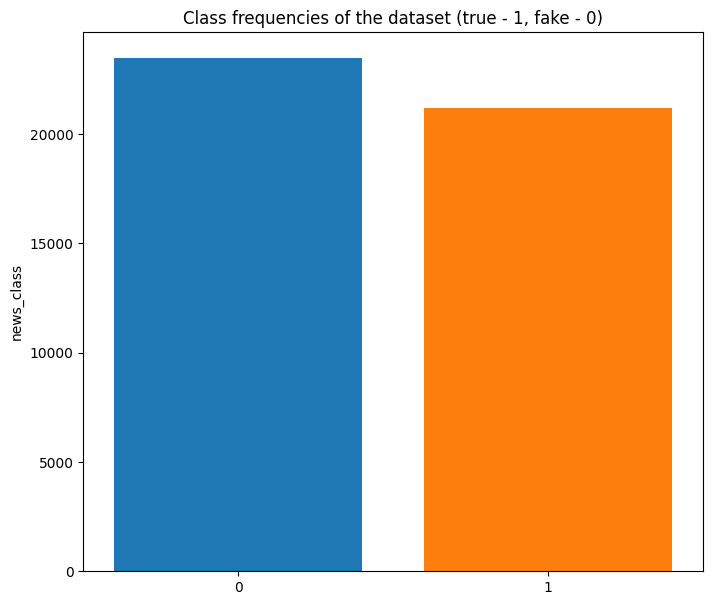

In [ ]:
plt.figure(figsize = [8, 7], clear = True, facecolor = 'white')

sns.barplot(x = news["news_class"].value_counts().index,
            y = news["news_class"].value_counts(),
            saturation = 1).set(title = "Class frequencies of the dataset (true - 1, fake - 0)");

In [ ]:
fig = px.pie(news, names = "subject", title = "counts in news_class", hole = 0.5,
            width = 1000, height = 500, color_discrete_sequence = px.colors.sequential.Sunset_r)

fig.update_traces(textposition = "inside", textinfo = "percent+label",
                  marker = dict(line = dict(width = 1.2, color = "#000000")))

fig.update_layout(title_x = 0.5, title_font = dict(size = 30), uniformtext_minsize = 25)

fig.show()


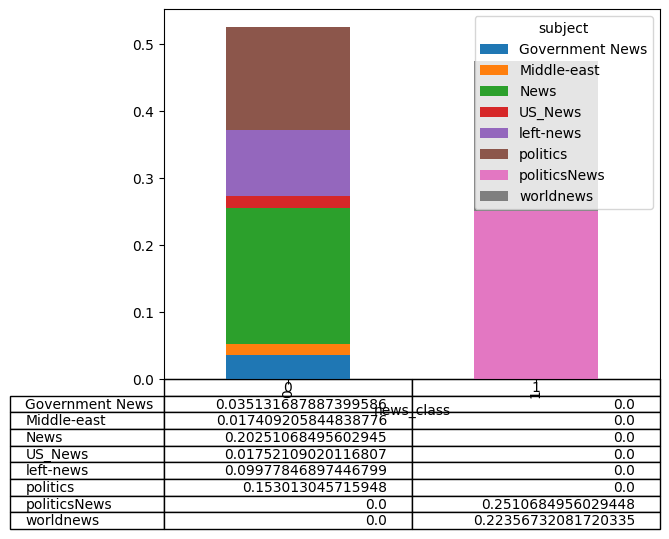

In [ ]:
pd.crosstab(news["news_class"], news["subject"],
            normalize = True).plot(kind = "bar", 
                                   backend = "matplotlib",
                                   legend = True, table = True, stacked = True);

<function matplotlib.pyplot.show(close=None, block=None)>

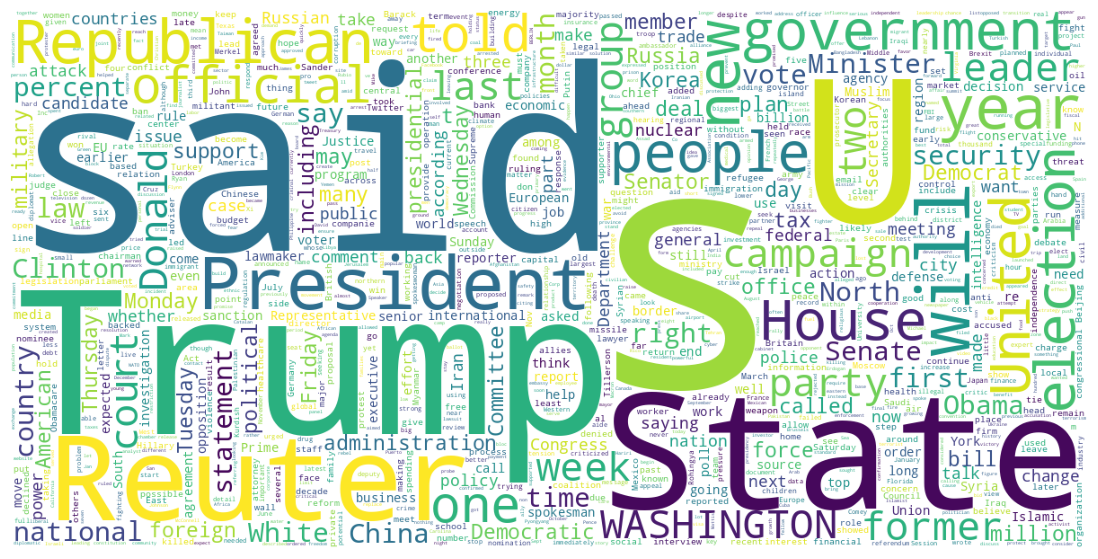

In [ ]:
#Wordcloud for true news

text = " ".join(i for i in true_news.text)

wc = WordCloud(background_color = "white", width = 1200, height = 600,
               contour_width = 0, contour_color = "red", max_words = 1000,
               scale = 1, collocations = False, repeat = True, min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [15, 7])
plt.imshow(wc)
plt.axis("off")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

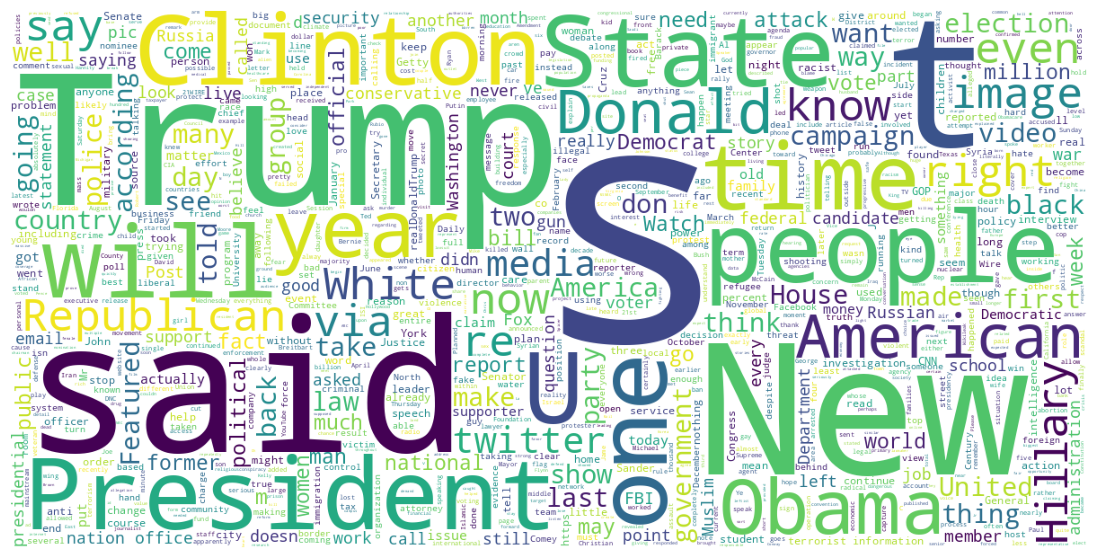

In [ ]:
#Wordcloud for fake news

text = " ".join(i for i in fake_news.text)

wc = WordCloud(background_color = "white", width = 1200, height = 600,
               contour_width = 0, contour_color = "red", max_words = 1000,
               scale = 1, collocations = False, repeat = True, min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [15, 7])
plt.imshow(wc)
plt.axis("off")
plt.show

In [ ]:
news["text"] = news["text"] + " " + news["title"]
news.drop(["title", "date", "subject"], axis = 1, inplace = True)

print(colored("\n'TITLE','DATE' AND 'SUBJECT' COLUMNS WERE SUCCESFULLY DROPPED...", "green"))


'TITLE','DATE' AND 'SUBJECT' COLUMNS WERE SUCCESFULLY DROPPED...


In [ ]:
#convert uppercase letters to lowercase letters

news["text"] = news["text"].apply(lambda x: " ".join(x.lower() for x in x.split()))

print(colored("\nCONVERTED SUCCESFULLY...", "green"))


CONVERTED SUCCESFULLY...


In [ ]:
#delete punctuation marks

news["text"] = news["text"].str.replace('[^\w\s]','')

print(colored("\nDELETED PUNCTUATION MARKS SUCCESFULLY...", "green"))


DELETED PUNCTUATION MARKS SUCCESFULLY...


In [ ]:
#delete numbers

news["text"] = news["text"].str.replace('\d','')

print(colored("\n NUMBERS DELETED SUCCESFULLY...", "green"))


 NUMBERS DELETED SUCCESFULLY...


In [ ]:
#delete stopwords

stop_words = set(stopwords.words("english"))
punctuation = list(string.punctuation)
stop_words.update(punctuation)

news["text"] = news["text"].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

print(colored("\nSTOPWORDS DELETED SUCCESFULLY...", "green"))


STOPWORDS DELETED SUCCESFULLY...


In [ ]:
#lemmatization. That is, we get the roots of the words

news["text"] = news["text"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

print(colored("\nLEMMATIZED SUCCESFULLY...", "green"))


LEMMATIZED SUCCESFULLY...


In [ ]:
#remove URLs

news["text"] = news["text"].apply(lambda x: " ".join(re.sub(r'http\S+', '', x) for x in x.split()))

print(colored("\nURLs WERE SUCCESFULLY REMOVED...", "green"))


URLs WERE SUCCESFULLY REMOVED...


In [ ]:
#look at the latest condition of the dataset

news.head(n = 10).style.background_gradient(cmap = "summer")

,text,news_class
0,washington reuters head conservative republican faction u congress voted month huge expansion national debt pay tax cut called fiscal conservative sunday urged budget restraint keeping sharp pivot way among republican u representative mark meadow speaking cbs face nation drew hard line federal spending lawmaker bracing battle january return holiday wednesday lawmaker begin trying pas federal budget fight likely linked issue immigration policy even november congressional election campaign approach republican seek keep control congress president donald trump republican want big budget increase military spending democrat also want proportional increase nondefense discretionary spending program support education scientific research infrastructure public health environmental protection trump administration already willing say going increase nondefense discretionary spending percent meadow chairman small influential house freedom caucus said program democrat saying thats enough need give government pay raise percent fiscal conservative dont see rationale eventually run people money said meadow among republican voted late december party debtfinanced tax overhaul expected balloon federal budget deficit add trillion year trillion national debt interesting hear mark talk fiscal responsibility democratic u representative joseph crowley said cbs crowley said republican tax bill would require united state borrow trillion paid future generation finance tax cut corporation rich one least fiscally responsible bill weve ever seen passed history house representative think going paying many many year come crowley said republican insist tax package biggest u tax overhaul year boost economy job growth house speaker paul ryan also supported tax bill recently went meadow making clear radio interview welfare entitlement reform party often call would top republican priority republican parlance entitlement program mean food stamp housing assistance medicare medicaid health insurance elderly poor disabled well program created washington assist needy democrat seized ryans early december remark saying showed republican would try pay tax overhaul seeking spending cut social program goal house republican may take back seat senate vote democrat needed approve budget prevent government shutdown democrat use leverage senate republican narrowly control defend discretionary nondefense program social spending tackling issue dreamer people brought illegally country child trump september put march expiration date deferred action childhood arrival daca program protects young immigrant deportation provides work permit president said recent twitter message want funding proposed mexican border wall immigration law change exchange agreeing help dreamer representative debbie dingell told cbs favor linking issue policy objective wall funding need daca clean said wednesday trump aide meet congressional leader discus issue followed weekend strategy session trump republican leader jan white house said trump also scheduled meet sunday florida republican governor rick scott want emergency aid house passed billion aid package hurricane florida texas puerto rico wildfire california package far exceeded billion requested trump administration senate yet voted aid u budget fight loom republican flip fiscal script,1
1,washington reuters transgender people allowed first time enlist u military starting monday ordered federal court pentagon said friday president donald trump administration decided appeal ruling blocked transgender ban two federal appeal court one washington one virginia last week rejected administration request put hold order lower court judge requiring military begin accepting transgender recruit jan justice department official said administration challenge ruling department defense announced releasing independent study issue coming week rather litigate interim appeal occurs administration decided wait dod study continue defend president lawful auth

In [ ]:
#get every words from dataset and append them to 'corpus' list
corpus = []
for i in news.text:
    for j in i.split():
        corpus.append(j.strip())

#count the words
counter = Counter(corpus)
common_words = counter.most_common(15)
dict(common_words)

{'trump': 142083,
 'said': 129065,
 'u': 68106,
 'state': 59332,
 'would': 55069,
 'president': 54472,
 'people': 41789,
 'republican': 39843,
 'one': 37357,
 'year': 34825,
 'new': 32550,
 'also': 31031,
 'clinton': 29889,
 'house': 29499,
 'say': 29111}

<function matplotlib.pyplot.show(close=None, block=None)>

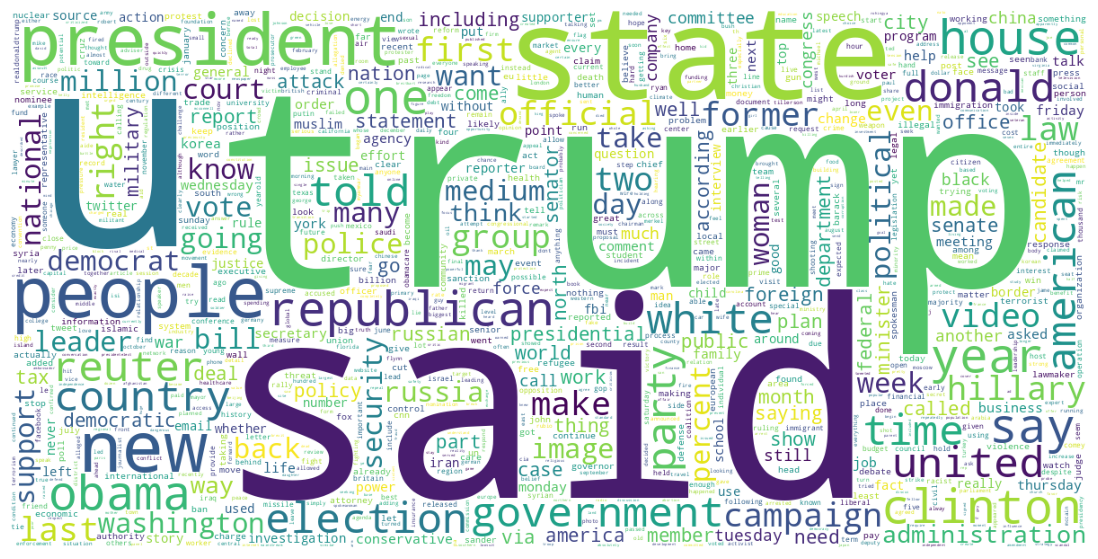

In [ ]:
#Wordcloud for whole dataset

text = " ".join(i for i in news.text)

wc = WordCloud(background_color = "white", width = 1200, height = 600,
               contour_width = 0, contour_color = "red", max_words = 1000,
               scale = 1, collocations = False, repeat = True, min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [15, 7])
plt.imshow(wc)
plt.axis("off")
plt.show

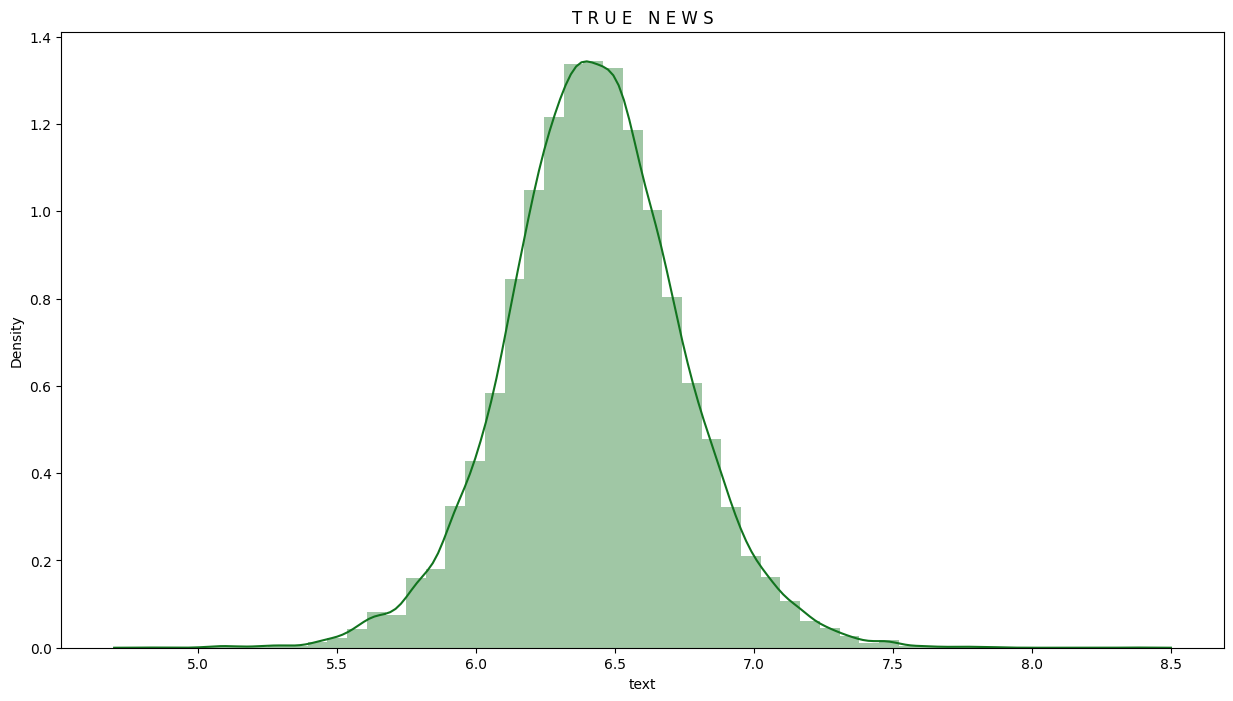

In [ ]:
#average word length in true news
import numpy as np

fig,ax = plt.subplots(figsize = (15, 8))
text_words = news[news["news_class"] == 1]["text"].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(text_words.map(lambda x: np.mean(x)), color = "#12741F", ax = ax).set_title("T R U E   N E W S");

In [ ]:
#divide the dataset into test and train sets

x = news["text"]
y = news["news_class"]

train_x, test_x, train_y, test_y = train_test_split(x, y,
                                                    test_size = 0.20,
                                                    shuffle = True,
                                                    random_state = 11)

print(colored("\nDIVIDED SUCCESFULLY...", "green"))


DIVIDED SUCCESFULLY...


In [ ]:
from tensorflow.keras.preprocessing import sequence
tokenizer = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(train_x)

tokenized_train = tokenizer.texts_to_sequences(train_x)
tokenized_test = tokenizer.texts_to_sequences(test_x)

train_x = sequence.pad_sequences(tokenized_train, maxlen = 300)
test_x = sequence.pad_sequences(tokenized_test, maxlen = 300)


In [ ]:
GLOVE_EMBEDDING = "/content/drive/MyDrive/Fake News Detection/glove.twitter.27B.100d.txt"

In [ ]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype = "float32")
embeddings_index = dict(get_coefs(*g.rstrip().rsplit(" ")) for g in open(GLOVE_EMBEDDING))

#_________________________________________________________________________________________#

#_________________________________________________________________________________________#

embeddings = np.stack(embeddings_index.values())
embedding_mean, embedding_std = embeddings.mean(), embeddings.std()
embedding_size = embeddings.shape[1]

word_index = tokenizer.word_index
nb_words = min(10000, len(word_index))

embedding_matrix = embedding_matrix = np.random.normal(embedding_mean, embedding_std, (nb_words, embedding_size))
for word, i in word_index.items():
    if i >= 10000:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
lr_reduce = ReduceLROnPlateau(monitor = "val_accuracy", patience = 2, factor = 0.5, min_lr = 0.00001)

In [ ]:
model = Sequential()

model.add(Embedding(10000,
                    output_dim = 100,
                    weights = [embedding_matrix],
                    input_length = 300,
                    trainable = False))

model.add(LSTM(units = 128,
               return_sequences = True,
               recurrent_dropout = 0.3,
               dropout = 0.3))

model.add(LSTM(units = 64,
               recurrent_dropout = 0.15,
               dropout = 0.15))

model.add(Dense(units = 32,
                activation = "relu"))

model.add(Dense(1,
                activation = "sigmoid"))

model.compile(optimizer = tf.keras.optimizers.Adam(lr = 0.01),
              loss = "binary_crossentropy",
              metrics = ["accuracy"])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 lstm (LSTM)                 (None, 300, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,168,769
Trainable params: 168,769
Non-trainable params: 1,000,000
_________________________________________________________________


In [ ]:
history = model.fit(train_x,
                    train_y,
                    batch_size = 128,
                    validation_data = (test_x, test_y),
                    epochs = 10,
                    callbacks = [lr_reduce])

Epoch 1/10
280/280 [==============================] - 387s 1s/step - loss: 0.1986 - accuracy: 0.9198 - val_loss: 0.1209 - val_accuracy: 0.9540 - lr: 0.0010
Epoch 2/10
280/280 [==============================] - 405s 1s/step - loss: 0.1218 - accuracy: 0.9545 - val_loss: 0.0874 - val_accuracy: 0.9670 - lr: 0.0010
Epoch 3/10
280/280 [==============================] - 432s 2s/step - loss: 0.0797 - accuracy: 0.9707 - val_loss: 0.0669 - val_accuracy: 0.9795 - lr: 0.0010
Epoch 4/10
280/280 [==============================] - 407s 1s/step - loss: 0.0460 - accuracy: 0.9848 - val_loss: 0.0181 - val_accuracy: 0.9937 - lr: 0.0010
Epoch 5/10
280/280 [==============================] - 393s 1s/step - loss: 0.0248 - accuracy: 0.9915 - val_loss: 0.0313 - val_accuracy: 0.9905 - lr: 0.0010
Epoch 6/10
280/280 [==============================] - 385s 1s/step - loss: 0.0203 - accuracy: 0.9929 - val_loss: 0.0140 - val_accuracy: 0.9955 - lr: 0.0010
Epoch 7/10
280/280 [==============================] - 399s 1s/st

In [ ]:
print("Model accuracy on the train set: ", model.evaluate(train_x, train_y)[1])
print("Model accuracy on the test set: ", model.evaluate(test_x, test_y)[1])

1118/1118 [==============================] - 95s 85ms/step - loss: 0.0060 - accuracy: 0.9978
Model accuracy on the train set:  0.9977902770042419
280/280 [==============================] - 29s 103ms/step - loss: 0.0163 - accuracy: 0.9946
Model accuracy on the test set:  0.9946296811103821


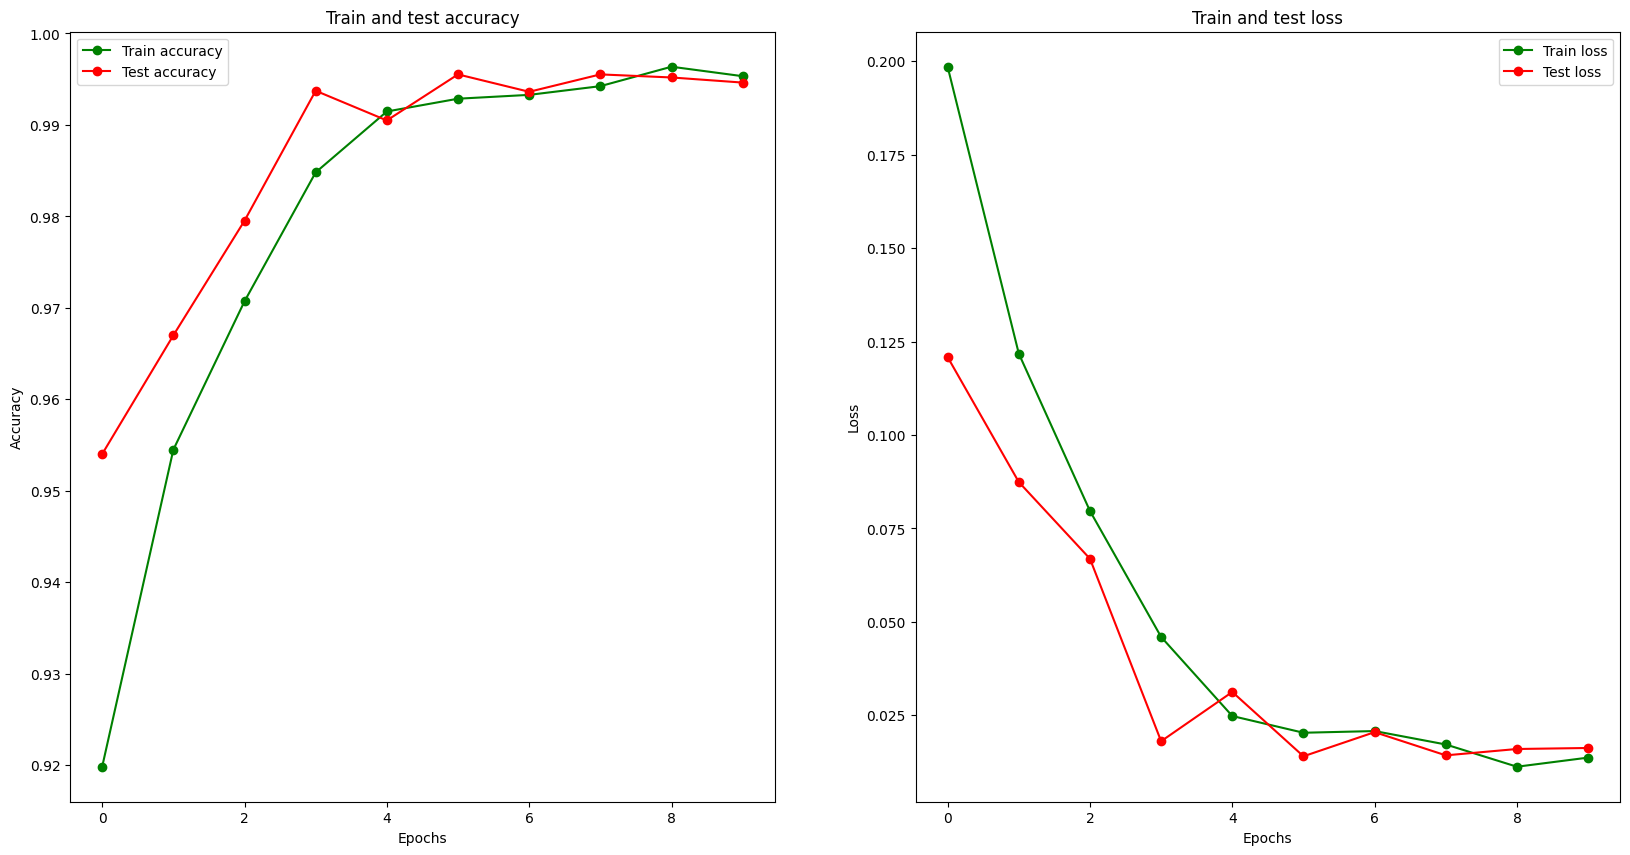

In [ ]:
epochs = [i for i in range(10)]

fig, ax = plt.subplots(1, 2)
train_acc = history.history["accuracy"]
train_loss = history.history["loss"]
val_acc = history.history["val_accuracy"]
val_loss = history.history["val_loss"]
fig.set_size_inches(20, 10)

ax[0].plot(epochs, train_acc, "go-", label = "Train accuracy")
ax[0].plot(epochs, val_acc, "ro-", label = "Test accuracy")
ax[0].set_title("Train and test accuracy")
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs, train_loss, "go-", label = "Train loss")
ax[1].plot(epochs, val_loss, "ro-", label = "Test loss")
ax[1].set_title("Train and test loss")
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [ ]:
prediction = model.predict(test_x)
classes_pred = np.argmax(prediction, axis = 1)

print(classification_report(test_y, classes_pred))

280/280 [==============================] - 34s 118ms/step
              precision    recall  f1-score   support

           0       0.52      1.00      0.68      4633
           1       0.00      0.00      0.00      4305

    accuracy                           0.52      8938
   macro avg       0.26      0.50      0.34      8938
weighted avg       0.27      0.52      0.35      8938



[[4633    0]
 [4305    0]]


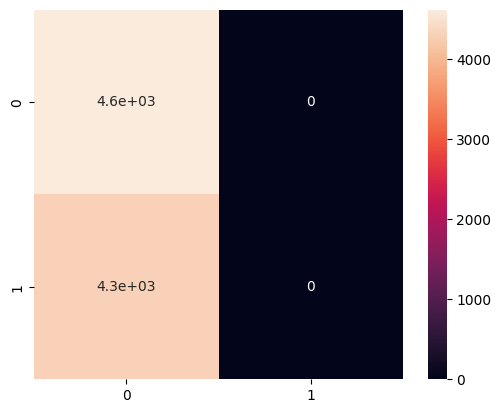

In [ ]:
conf_mat = confusion_matrix(test_y, classes_pred)
print(conf_mat)

sns.heatmap(conf_mat, square = True, annot = True, robust = True)
plt.show()